In [1]:
import numpy as np
import pylab as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from collections import OrderedDict
from palettable import wesanderson as wes
from scipy import io
import RSAs as rs
from itertools import combinations 
from math import factorial
import palettable 


/Users/veronikasamborska/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.1' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
your_path = '/Users/veronikasamborska/Desktop/' # change path to where github folder is stored on your machine
# load data (for the main figures we used data after removing variance associated with physical movement)
def import_data(your_path):
    HP = io.loadmat(your_path +'notebooks_paper/cells/data_recordings/HP.mat')
    PFC = io.loadmat(your_path + 'notebooks_paper/cells/data_recordings/PFC.mat')
    return HP, PFC

HP, PFC =  import_data(your_path)

def import_data_after_DLC(your_path):
    HP = io.loadmat(your_path +'notebooks_paper/cells/data_recordings/HP_dlc_pca.mat')
    PFC = io.loadmat(your_path + 'notebooks_paper/cells/data_recordings/PFC_dlc_pca.mat')
    return HP, PFC

HP_dlc, PFC_dlc =  import_data_after_DLC(your_path)


In [3]:
def task_ind(task, a_pokes, b_pokes):
    """ Create Task IDs for that are consistent: in Task 1 A and B at left right extremes, in Task 2 B is one of the diagonal ones, 
    in Task 3  B is top or bottom """
    
    taskid = np.zeros(len(task))
    taskid[b_pokes == 10 - a_pokes] = 1     
    taskid[np.logical_or(np.logical_or(b_pokes == 2, b_pokes == 3), np.logical_or(b_pokes == 7, b_pokes == 8))] = 2  
    taskid[np.logical_or(b_pokes ==  1, b_pokes == 9)] = 3
         
  
    return taskid

def _cpd(X,y):
    '''Evaluate coefficient of partial determination for each predictor in X'''
    pdes = np.linalg.pinv(X)
    pe = np.matmul(pdes,y)
    Y_predict = np.matmul(X,pe)
    sse = np.sum((Y_predict - y)**2, axis=0)
    cpd = np.zeros([X.shape[1]])
    for i in range(X.shape[1]):
        X_i = np.delete(X,i,axis=1)
        pdes_i = np.linalg.pinv(X_i)
        pe_i = np.matmul(pdes_i,y)
        Y_predict_i = np.matmul(X_i,pe_i)
        sse_X_i = np.sum((Y_predict_i- y)**2, axis=0)
        cpd[i]=(sse_X_i-sse)/sse_X_i
    return cpd
 
def animal_exp_permute(all_sessions_HP,all_sessions_PFC):
   
    HP_1 = 15; HP_2 = 7 # CA1 sessions
    PFC_1 = 9; PFC_2 = 16; PFC_3 = 13 # PFC sessions
    
    # trial info data for each CA1 and PFC animal
    HP_all_sessions_1 = all_sessions_HP['DM'][0][:HP_1]; HP_all_sessions_2 = all_sessions_HP['DM'][0][HP_1:HP_1+HP_2]
    HP_all_sessions_3 = all_sessions_HP['DM'][0][HP_1+HP_2:]

    PFC_all_sessions_1 = all_sessions_PFC['DM'][0][:PFC_1]; PFC_all_sessions_2 = all_sessions_PFC['DM'][0][PFC_1:PFC_1+PFC_2]
    PFC_all_sessions_3 = all_sessions_PFC['DM'][0][PFC_1+PFC_2:PFC_1+PFC_2+PFC_3]; PFC_all_sessions_4 = all_sessions_PFC['DM'][0][PFC_1+PFC_2+PFC_3:]
    
    # firing rate data for each CA1 and PFC animal
    HP_all_sessions_1_fr = all_sessions_HP['Data'][0][:HP_1]; HP_all_sessions_2_fr = all_sessions_HP['Data'][0][HP_1:HP_1+HP_2]
    HP_all_sessions_3_fr = all_sessions_HP['Data'][0][HP_1+HP_2:]

    PFC_all_sessions_1_fr = all_sessions_PFC['Data'][0][:PFC_1]; PFC_all_sessions_2_fr = all_sessions_PFC['Data'][0][PFC_1:PFC_1+PFC_2]
    PFC_all_sessions_3_fr = all_sessions_PFC['Data'][0][PFC_1+PFC_2:PFC_1+PFC_2+PFC_3];   PFC_all_sessions_4_fr = all_sessions_PFC['Data'][0][PFC_1+PFC_2+PFC_3:]
   
    all_subjects_DM = [HP_all_sessions_1,HP_all_sessions_2, HP_all_sessions_3,PFC_all_sessions_1,PFC_all_sessions_2, PFC_all_sessions_3,PFC_all_sessions_4]
    all_subjects_fr = [HP_all_sessions_1_fr,HP_all_sessions_2_fr, HP_all_sessions_3_fr,PFC_all_sessions_1_fr,PFC_all_sessions_2_fr, PFC_all_sessions_3_fr,PFC_all_sessions_4_fr]

    return  all_subjects_DM ,all_subjects_fr


In [4]:
def extract_trials(data, t_start, t_end, perm_n = False, animal_perm = False): 
    '''This function arranges data in a format used in later RSA analysis - finds A reward, A non-rewarded,
    B reward, B non-rewarded, Initiation average firing rates for each neuron.
    t_start and t_end are used to extract firing rates in time windows around and after choice.
    perm_n here is used solely to access data.'''
    if perm_n: # if it's a permutation test access data this way --> 
        dm = data[0]
        firing = data[1]
        if animal_perm == True: # if it's an animal based permutation test 
            dm = np.concatenate(dm,0)
            firing = np.concatenate(firing,0)
    
    else:
        dm = data['DM'][0]
        firing = data['Data'][0]   
    
            
    neurons = 0
    for s in firing:
        neurons += s.shape[1]

    a_1_nr = np.zeros((neurons)); a_2_nr = np.zeros((neurons)); a_3_nr = np.zeros((neurons))
    a_1_r = np.zeros((neurons)); a_2_r = np.zeros((neurons)); a_3_r = np.zeros((neurons))
    b_1_nr = np.zeros((neurons)); b_2_nr = np.zeros((neurons)); b_3_nr = np.zeros((neurons))
    b_1_r = np.zeros((neurons)); b_2_r = np.zeros((neurons)); b_3_r = np.zeros((neurons))
    i_1 = np.zeros((neurons)); i_2 = np.zeros((neurons)); i_3 = np.zeros((neurons))
    init_start = 24;  init_stop = 26 # initiation is held the same whereas t_start and t_end allow to select for windows after choice
    
    n_neurons_cum = 0;
    for  s, sess in enumerate(dm):
        DM = dm[s]
        firing_rates = firing[s]
        n_trials, n_neurons, n_timepoints = firing_rates.shape
        n_neurons_cum += n_neurons
        # trial information
        choices = DM[:,1]; task =  DM[:,5]; a_pokes = DM[:,6]; b_pokes = DM[:,7]; reward = DM[:,2]  
        taskid = task_ind(task, a_pokes, b_pokes)
        # task IDs 
        task_1 = np.where(taskid == 1)[0]; task_2 = np.where(taskid == 2)[0]; task_3 = np.where(taskid == 3)[0]
        # find trial indicies for A rewarded choices
        task_1_a_r = np.where((choices == 1) & (reward == 1) & (taskid == 1))[0]                              
        task_2_a_r = np.where((choices == 1) & (reward == 1) & (taskid == 2))[0]            
        task_3_a_r = np.where((choices == 1) & (reward == 1) & (taskid == 3))[0]    
        # find trial indicies for A non-rewarded choices
        task_1_a_nr = np.where((choices == 1) & (reward == 0) & (taskid == 1))[0]                                 
        task_2_a_nr = np.where((choices == 1) & (reward == 0) & (taskid == 2))[0]            
        task_3_a_nr = np.where((choices == 1) & (reward == 0) & (taskid == 3))[0]    
        # find trial indicies for B rewarded choices
        task_1_b_r = np.where((choices == 0) & (reward == 1) & (taskid == 1))[0]                                 
        task_2_b_r = np.where((choices == 0) & (reward == 1) & (taskid == 2))[0]          
        task_3_b_r = np.where((choices == 0) & (reward == 1) & (taskid == 3))[0]       
       # find trial indicies for B non-rewarded choices
        task_1_b_nr = np.where((choices == 0) & (reward == 0) & (taskid == 1))[0]                                 
        task_2_b_nr = np.where((choices == 0) & (reward == 0) & (taskid == 2))[0]            
        task_3_b_nr = np.where((choices == 0) & (reward == 0) & (taskid == 3))[0]    

        # store mean firing rates for A reward, A no reward, B reward, B no reward, Initiation in all tasks
        a_1_r[n_neurons_cum-n_neurons:n_neurons_cum] =  np.mean(np.mean(firing_rates[task_1_a_r,:, t_start:t_end],2),0)
        a_2_r[n_neurons_cum-n_neurons:n_neurons_cum] =  np.mean(np.mean(firing_rates[task_2_a_r,:, t_start:t_end],2),0)
        a_3_r[n_neurons_cum-n_neurons:n_neurons_cum] =  np.mean(np.mean(firing_rates[task_3_a_r,:, t_start:t_end],2),0)
         
        a_1_nr[n_neurons_cum-n_neurons:n_neurons_cum] =  np.mean(np.mean(firing_rates[task_1_a_nr,:, t_start:t_end],2),0)
        a_2_nr[n_neurons_cum-n_neurons:n_neurons_cum] =  np.mean(np.mean(firing_rates[task_2_a_nr,:, t_start:t_end],2),0)
        a_3_nr[n_neurons_cum-n_neurons:n_neurons_cum] =  np.mean(np.mean(firing_rates[task_3_a_nr,:, t_start:t_end],2),0)
 
        b_1_r[n_neurons_cum-n_neurons:n_neurons_cum] =  np.mean(np.mean(firing_rates[task_1_b_r,:, t_start:t_end],2),0)
        b_2_r[n_neurons_cum-n_neurons:n_neurons_cum] =  np.mean(np.mean(firing_rates[task_2_b_r,:, t_start:t_end],2),0)
        b_3_r[n_neurons_cum-n_neurons:n_neurons_cum] =  np.mean(np.mean(firing_rates[task_3_b_r,:, t_start:t_end],2),0)
         
        b_1_nr[n_neurons_cum-n_neurons:n_neurons_cum] =  np.mean(np.mean(firing_rates[task_1_b_nr,:, t_start:t_end],2),0)
        b_2_nr[n_neurons_cum-n_neurons:n_neurons_cum] =  np.mean(np.mean(firing_rates[task_2_b_nr,:, t_start:t_end],2),0)
        b_3_nr[n_neurons_cum-n_neurons:n_neurons_cum] =  np.mean(np.mean(firing_rates[task_3_b_nr,:, t_start:t_end],2),0)
        
        i_1[n_neurons_cum-n_neurons:n_neurons_cum] = np.mean(np.mean(firing_rates[task_1,:, init_start:init_stop],2),0)
        i_2[n_neurons_cum-n_neurons:n_neurons_cum] = np.mean(np.mean(firing_rates[task_2,:, init_start:init_stop],2),0)
        i_3[n_neurons_cum-n_neurons:n_neurons_cum] = np.mean(np.mean(firing_rates[task_3,:, init_start:init_stop],2),0)

    matrix_for_correlations = np.vstack([a_1_r,a_1_nr,a_2_r,a_2_nr,a_3_r,a_3_nr,\
                                        i_1,i_3,i_2, b_3_r, b_3_nr, b_2_r, b_2_nr, b_1_r, b_1_nr]) 
  
    return matrix_for_correlations


In [5]:
def regression_RSA(HP, PFC, t_start, t_end, perm_n = False, animal_perm = False, dlc = False):
    # extract firing rates for HP data and compute a correlation matrix 
    matrix_for_correlations_HP = extract_trials(HP, t_start, t_end, perm_n = False, animal_perm = animal_perm)
    correlation_m = np.corrcoef(matrix_for_correlations_HP)
    np.fill_diagonal(correlation_m,np.nan); correlation_m_f = correlation_m.flatten()
    correlation_m_f = correlation_m_f[~np.isnan(correlation_m_f)]
    
    # extract firing rates for PFC data and compute a correlation matrix 
    matrix_for_correlations_PFC = extract_trials(PFC, t_start, t_end, perm_n = False,  animal_perm = animal_perm)
    correlation_m_PFC = np.corrcoef(matrix_for_correlations_PFC)
    np.fill_diagonal(correlation_m_PFC,np.nan); correlation_m_PFC_f = correlation_m_PFC.flatten()
    correlation_m_PFC_f = correlation_m_PFC_f[~np.isnan(correlation_m_PFC_f)]
    
    # port RDM
    physical_rsa = np.asarray(rs.RSA_physical_rdm(),dtype = np.float32)
    np.fill_diagonal(physical_rsa,np.nan)
    physical_rsa  = physical_rsa.flatten(); physical_rsa = physical_rsa[~np.isnan(physical_rsa)]
   
    # choice A/B RDM
    choice_ab_rsa = np.asarray(rs.RSA_a_b_rdm(),dtype = np.float32)
    np.fill_diagonal(choice_ab_rsa,np.nan); choice_ab_rsa = choice_ab_rsa.flatten()
    choice_ab_rsa = choice_ab_rsa[~np.isnan(choice_ab_rsa)]
 
    # outcome RDM
    reward_no_reward = np.asarray(rs.reward_rdm(),dtype = np.float32)
    np.fill_diagonal(reward_no_reward,np.nan); reward_no_reward = reward_no_reward.flatten()
    reward_no_reward = reward_no_reward[~np.isnan(reward_no_reward)]
    
    # outcome at A vs B RDM
    reward_at_choices = np.asarray(rs.reward_choice_space(),dtype = np.float32)
    np.fill_diagonal(reward_at_choices,np.nan); reward_at_choices = reward_at_choices.flatten()
    reward_at_choices = reward_at_choices[~np.isnan(reward_at_choices)]
    
    # choice vs initiation RDM
    choice_initiation_rsa =  np.asarray(rs.choice_vs_initiation(), dtype = np.float32)
    np.fill_diagonal(choice_initiation_rsa,np.nan); choice_initiation_rsa = choice_initiation_rsa.flatten()
    choice_initiation_rsa = choice_initiation_rsa[~np.isnan(choice_initiation_rsa)]
    
    # problem specific A choice RDM
    a_specific = np.asarray(rs.a_bs_task_specific(), dtype = np.float32); a_specific[6:,6:] = 0; 
    np.fill_diagonal(a_specific,np.nan);  a_specific = a_specific.flatten(); a_specific = a_specific[~np.isnan(a_specific)]
    ones = np.ones(len(choice_ab_rsa))
    
    # create a design matrix consisting of all RDMs
    if dlc == False:
        X = np.vstack([physical_rsa, choice_ab_rsa, reward_no_reward, reward_at_choices, choice_initiation_rsa, a_specific,ones]).T
    else: # exclude physical port RSA if data after dlc 
        X = np.vstack([choice_ab_rsa, reward_no_reward, reward_at_choices, choice_initiation_rsa, a_specific,ones]).T
    # calculate unique variance explained by each RDM
    cpd_HP = _cpd(X, correlation_m_f); cpd_PFC = _cpd(X, correlation_m_PFC_f)
    
    if perm_n: # if it's a permutation test
        all_subjects_DM = np.concatenate((HP['DM'][0],PFC['DM'][0]),0);  all_subjects_fr = np.concatenate((HP['Data'][0],PFC['Data'][0]),0)    
        n_sessions = np.arange(len(HP['DM'][0])+len(PFC['DM'][0]))
        pfc_perm = np.zeros((int(perm_n),X.shape[1])); hp_perm = np.zeros((int(perm_n),X.shape[1])) # array to store permuted cpds 
        if animal_perm == False:
            for i in range(perm_n): # i is inidices for PFC if it's the animal permutation test
                np.random.shuffle(n_sessions) # shuffle PFC/HP sessions
                indices_HP = n_sessions[:len(HP['DM'][0])]; indices_PFC = n_sessions[len(HP['DM'][0]):]
                # PFC shuffled data
                DM_PFC = all_subjects_DM[np.asarray(indices_PFC)]; Data_PFC = all_subjects_fr[np.asarray(indices_PFC)]
                data_PFC = [DM_PFC, Data_PFC]
                # HP shuffled data
                DM_HP = all_subjects_DM[np.asarray(indices_HP)]; Data_HP = all_subjects_fr[np.asarray(indices_HP)]
                data_HP = [DM_HP, Data_HP]

                # extract firing rates for shuffled PFC data and compute a correlation matrix 
                matrix_for_correlations_perm_PFC = extract_trials(data_PFC, t_start, t_end, perm_n = perm_n, animal_perm = animal_perm)            
                matrix_for_correlations_perm_PFC = np.corrcoef(matrix_for_correlations_perm_PFC)
                np.fill_diagonal(matrix_for_correlations_perm_PFC,np.nan)
                matrix_for_correlations_perm_PFC = matrix_for_correlations_perm_PFC.flatten()
                y_perm_PFC = matrix_for_correlations_perm_PFC[~np.isnan(matrix_for_correlations_perm_PFC)]
                # calculate unique variance explained by each RDM in PFC shuffled data
                cpd_PFC_perm = _cpd(X, y_perm_PFC)

                # extract firing rates for shuffled HP data and compute a correlation matrix 
                matrix_for_correlations_perm_HP = extract_trials(data_HP, t_start, t_end, perm_n = perm_n,animal_perm = animal_perm)
                matrix_for_correlations_perm_HP  = np.corrcoef(matrix_for_correlations_perm_HP)
                np.fill_diagonal(matrix_for_correlations_perm_HP,np.nan)
                matrix_for_correlations_perm_HP = matrix_for_correlations_perm_HP.flatten()
                y_perm_HP = matrix_for_correlations_perm_HP[~np.isnan(matrix_for_correlations_perm_HP)]
                # calculate unique variance explained by each RDM in HP shuffled data
                cpd_HP_perm = _cpd(X, y_perm_HP)
                pfc_perm[i,:] = cpd_PFC_perm;  hp_perm[i,:]  = cpd_HP_perm
        else:
            animals_PFC = [0,1,2,3];  animals_HP = [4,5,6]  
            m, n = len(animals_PFC), len(animals_HP)
            num_rounds = factorial(m + n) / (factorial(m)*factorial(n))
            pfc_perm = np.zeros((int(num_rounds),X.shape[1])); hp_perm = np.zeros((int(num_rounds),X.shape[1])) # array to store permuted cpds 
            all_subjects_DM, all_subjects_fr  = animal_exp_permute(HP,PFC)
            nn = 0
            for indices_PFC in combinations(range(m + n), m):
                indices_HP = [i for i in range(m + n) if i not in indices_PFC]
                DM_PFC = np.asarray(all_subjects_DM)[np.asarray(indices_PFC)]
                Data_PFC = np.asarray(all_subjects_fr)[np.asarray(indices_PFC)]; data_PFC = [DM_PFC,Data_PFC]
                       
                DM_HP = np.asarray(all_subjects_DM)[np.asarray(indices_HP)]
                Data_HP = np.asarray(all_subjects_fr)[np.asarray(indices_HP)]
                data_HP = [DM_HP,Data_HP]
            
                matrix_for_correlations_perm_PFC = extract_trials(data_PFC, t_start, t_end, perm_n  = perm_n,  animal_perm = animal_perm)
                matrix_for_correlations_perm_PFC = np.corrcoef(matrix_for_correlations_perm_PFC)
                np.fill_diagonal(matrix_for_correlations_perm_PFC,np.nan)
                matrix_for_correlations_perm_PFC= matrix_for_correlations_perm_PFC.flatten()
                y_perm_PFC = matrix_for_correlations_perm_PFC[~np.isnan(matrix_for_correlations_perm_PFC)]
                cpd_PFC_perm = _cpd(X,y_perm_PFC)

                matrix_for_correlations_perm_HP = extract_trials(data_HP, t_start, t_end, perm_n  = perm_n,  animal_perm = animal_perm)
                matrix_for_correlations_perm_HP  = np.corrcoef(matrix_for_correlations_perm_HP)
                np.fill_diagonal(matrix_for_correlations_perm_HP,np.nan)
                matrix_for_correlations_perm_HP= matrix_for_correlations_perm_HP.flatten()
                y_perm_HP = matrix_for_correlations_perm_HP[~np.isnan(matrix_for_correlations_perm_HP)]
                cpd_HP_perm = _cpd(X,y_perm_HP)         
                pfc_perm[nn,:] = cpd_PFC_perm;  hp_perm[nn,:]  = cpd_HP_perm
                nn += 1
    
    return cpd_PFC, cpd_HP, matrix_for_correlations_PFC, matrix_for_correlations_HP, pfc_perm, hp_perm




In [6]:
def RSA_across_time_plot(HP, PFC, perm_n = 5, animal_perm = False, dlc = False):
    if dlc == False:
        cue = np.arange(34,62);  reward = np.arange(35,63) # indicies to loop through time around and after choice          ab = 0; re = 1;  re_ab = 2; ch_i = 3; tsp = 4
        prtd = 0; ab = 1; re = 2;  re_ab = 3; ch_i = 4; tsp = 5
        p_list_99 = np.zeros((len(reward),6)) ;  p_list_95 = np.zeros((len(reward),6)) # list to store 99th and 95th percentiles at different time points

    else:
        cue = np.arange(37,61);  reward = np.arange(38,62) # indicies to loop through time around and after choice   
        ab = 0; re = 1;  re_ab = 2; ch_i = 3; tsp = 4
        p_list_99 = np.zeros((len(reward),5)) ;  p_list_95 = np.zeros((len(reward),5)) # list to store 99th and 95th percentiles at different time points

    corr_HP = []; corr_PFC = [] # list to store correlation matrices at different time points
    # list to store real differences 
    diff_space = []; diff_a_b = [];  diff_rew = []; diff_rew_ab = []; diff_ch_init = []; diff_a_spec = []; 
    # indicies for port, ab choice, reward cpds 
    cpd_PFC_list = [];  cpd_HP_list = []
    k = 0
    for start,end in zip(cue, reward): # loop through the time points around and after choice and calculate RSAs
        cpd_PFC, cpd_HP, matrix_for_correlations_PFC, matrix_for_correlations_HP, pfc_perm, hp_perm = regression_RSA(HP,PFC, start, end, perm_n = perm_n, animal_perm = animal_perm, dlc = dlc)  
         # find 95th and 99th percentiles
       
        corr_HP.append(matrix_for_correlations_HP); corr_PFC.append(matrix_for_correlations_PFC)
        cpd_PFC_list.append(cpd_PFC);  cpd_HP_list.append(cpd_HP)
        
        if dlc == False:
            diff_space.append((cpd_HP[prtd]- cpd_PFC[prtd]));
            p_list_95[k,prtd] = np.percentile((hp_perm[:,prtd] - pfc_perm[:,prtd]),95,0); p_list_99[k,prtd] = np.percentile((hp_perm[:,prtd] - pfc_perm[:,prtd]),99,0)
    
        diff_a_b.append((cpd_HP[ab]- cpd_PFC[ab]))
        diff_rew.append((cpd_PFC[re]- cpd_HP[re]));  diff_rew_ab.append((cpd_HP[re_ab]- cpd_PFC[re_ab]))
        diff_ch_init.append((cpd_PFC[ch_i]- cpd_HP[ch_i])); diff_a_spec.append((cpd_HP[tsp]- cpd_PFC[tsp]));
        p_list_95[k,ab] = np.percentile((hp_perm[:,ab] - pfc_perm[:,ab]),95,0); p_list_95[k,re] = np.percentile((pfc_perm[:,re] - hp_perm[:,re]),95,0)
        p_list_95[k,re_ab] = np.percentile((hp_perm[:,re_ab] - pfc_perm[:,re_ab]),95,0);  p_list_95[k,ch_i] = np.percentile((pfc_perm[:,ch_i] - hp_perm[:,ch_i]),95,0)
        p_list_95[k,tsp] = np.percentile((hp_perm[:,tsp] - pfc_perm[:,tsp]),95,0)
    
        p_list_99[k,ab] =  np.percentile((hp_perm[:,ab] - pfc_perm[:,ab]),99,0); p_list_99[k,re] = np.percentile((pfc_perm[:,re] - hp_perm[:,re]),99,0) 
        p_list_99[k,re_ab] = np.percentile((hp_perm[:,re_ab] - pfc_perm[:,re_ab]),99,0);  p_list_99[k,ch_i] = np.percentile((pfc_perm[:,ch_i] - hp_perm[:,ch_i]),99,0)
        p_list_99[k,tsp] = np.percentile((hp_perm[:,tsp] - pfc_perm[:,tsp]),99,0)
        k += 1
    
    cpd_PFC_list = np.asarray(cpd_PFC_list); cpd_HP_list = np.asarray(cpd_HP_list)
    p_list_95 = np.asarray(p_list_95); p_list_99 = np.asarray(p_list_99)
    cpd_p_val_mult_compar_95 = np.max(p_list_95,0); cpd_p_val_mult_compar_99 = np.max(p_list_99,0)
    if dlc == False:
        space_sig = np.where(diff_space > cpd_p_val_mult_compar_95[prtd])[0]; 
        space_sig_99 = np.where(diff_space > cpd_p_val_mult_compar_99[prtd])[0]; 
        
    a_b_sig = np.where(diff_a_b > cpd_p_val_mult_compar_95[ab])[0];  a_b_sig_99 = np.where(diff_a_b > cpd_p_val_mult_compar_99[ab])[0]
    rew_sig = np.where(diff_rew > cpd_p_val_mult_compar_95[re])[0]; rew_ab_sig = np.where(diff_rew_ab > cpd_p_val_mult_compar_95[re_ab])[0]
    ch_init_sig = np.where(diff_ch_init > cpd_p_val_mult_compar_95[ch_i])[0];  a_spec_sig = np.where(diff_a_spec > cpd_p_val_mult_compar_95[tsp])[0]
    rew_sig_99 = np.where(diff_rew > cpd_p_val_mult_compar_99[re])[0]; rew_ab_sig_99 = np.where(diff_rew_ab > cpd_p_val_mult_compar_99[re_ab])[0]
    ch_init_sig_99 = np.where(diff_ch_init > cpd_p_val_mult_compar_99[ch_i])[0]; a_spec_sig_99 = np.where(diff_a_spec > cpd_p_val_mult_compar_99[tsp])[0]
    
    inds = [1,8,int(len(cue)/2),len(cue)-1]; isl = wes.Royal2_5.mpl_colors; k = 'grey'
    if dlc == False:
        sbplt = 7
        sign_95 = [space_sig, a_b_sig, rew_sig, rew_ab_sig, ch_init_sig, a_spec_sig]
        sign_99 = [space_sig_99, a_b_sig_99, rew_sig_99, rew_ab_sig_99, ch_init_sig_99, a_spec_sig_99]
        pred_str = ['Port', 'A vs B choice', 'Outcome', 'Outcome at A vs B', 'Choice vs Initiation', 'Problem Specific A choice']
    else:
        sbplt = 7
        sign_95 = [a_b_sig, rew_sig, rew_ab_sig, ch_init_sig, a_spec_sig]
        sign_99 = [a_b_sig_99, rew_sig_99, rew_ab_sig_99, ch_init_sig_99, a_spec_sig_99]
        pred_str = ['A vs B choice', 'Outcome', 'Outcome at A vs B', 'Choice vs Initiation', 'Problem Specific A choice']
    plt.figure(figsize = (15,2.5))
    offset = [6,3,4,3,5,1]
    for pred in np.arange(len(sign_95)):
        plt.subplot(1,sbplt, pred+1)
        plt.plot(cpd_HP_list[:,pred]*100, color = isl[0])
        plt.plot(cpd_PFC_list[:,pred]*100, color = isl[3])
        plt.xticks(inds,['C', 'R', '+0.5','+1'])
        plt.plot(sign_95[pred], np.ones(len(sign_95[pred]))*(np.max([cpd_HP_list[:,pred],cpd_PFC_list[:,pred]]))*100+ offset[pred], '.', markersize = 2, color = 'grey')
        plt.plot(sign_99[pred], np.ones(len(sign_99[pred]))*(np.max([cpd_HP_list[:,pred],cpd_PFC_list[:,pred]]))*100+ offset[pred], '.', markersize = 4, color = 'grey',label = '< .001 diff PFC and HP ')
        plt.ylim(-0.1,(np.max([cpd_HP_list[:,pred], cpd_PFC_list[:,pred]]))*100+offset[pred]+1)
        plt.ylabel('CPD (%)') 
        plt.title(pred_str[pred])
        plt.xlabel('Time in Trial (s)')
    plt.tight_layout(); sns.despine()
    
    cmap =  palettable.scientific.sequential.Acton_3.mpl_colormap
    c_ch_HP = corr_HP[inds[0]]; c_ch_PFC = corr_PFC[inds[0]]
    c_rew_HP = corr_HP[inds[1]]; c_rew_PFC = corr_PFC[inds[1]]
    
    all_corr_ = [np.corrcoef(c_ch_HP)-np.mean(np.corrcoef(c_ch_HP)), np.corrcoef(c_ch_PFC)-np.mean(np.corrcoef(c_ch_PFC)),\
                np.corrcoef(c_rew_HP)-np.mean(np.corrcoef(c_rew_HP)), np.corrcoef(c_rew_PFC)-np.mean(np.corrcoef(c_rew_PFC))]
    title_str = ['CA1 Choice Time', 'PFC Choice Time', 'CA1 Reward Time', 'PFC Reward Time']
    plt.figure(figsize = (20,10))
    for i, ii in enumerate(all_corr_):
        plt.subplot(2,2,i+1)
        plt.imshow(ii, aspect = 1, cmap = cmap)
        plt.xticks(range(15), ('A T1 R', 'A T1 NR','A T2 R', 'A T2 NR',\
                           'A T3 R','A T3 NR', ' I T1',\
                           'I T3', 'I T2', 'B T3 R',\
                           ' B T3 NR','B T2 R', 'B T2 NR', 'B T1 R', 'B T1 NR'), rotation = 'vertical')
               
        plt.yticks(range(15), ('A T1 R', 'A T1 NR','A T2 R', 'A T2 NR',\
                           'A T3 R','A T3 NR', ' I T1',\
                           'I T3', ' T2', 'B T3 R',\
                           ' B T3 NR','B T2 R', 'B T2 NR', 'B T1 R', 'B T1 NR'))
        
        plt.title(title_str[i])
        plt.colorbar(label ='Correlation Coefficient' )
      
    plt.tight_layout()
    
    physical_rsa = np.asarray(rs.RSA_physical_rdm(),dtype=np.float32)
    choice_ab_rsa = np.asarray(rs.RSA_a_b_rdm(),dtype=np.float32)   
    reward_no_reward = np.asarray(rs.reward_rdm(),dtype=np.float32)
    reward_at_choices = rs.reward_choice_space()
    choice_initiation_rsa =  np.asarray(rs.choice_vs_initiation(),dtype=np.float)       
    a_bs_task_specific_rsa = np.asarray(rs.a_bs_task_specific(),dtype=np.float)
    a_specific =  np.asarray(a_bs_task_specific_rsa,dtype=np.float32); a_specific[6:,6:]= 0
    if dlc == False:
        all_rsas =[physical_rsa,choice_ab_rsa,reward_no_reward,reward_at_choices,choice_initiation_rsa,a_specific]
    else:
        all_rsas =[choice_ab_rsa,reward_no_reward,reward_at_choices,choice_initiation_rsa,a_specific]

    plt.figure(figsize = (20,10))
    for i,ii in enumerate(all_rsas):
        
        plt.subplot(1,sbplt,i+1)
        plt.imshow(ii,cmap = cmap)
        plt.xticks(range(15), ('A T1 R', 'A T1 NR','A T2 R', 'A T2 NR',\
                           'A T3 R','A T3 NR', ' I T1',\
                           'I T3', 'I T2', 'B T3 R',\
                           ' B T3 NR','B T2 R', 'B T2 NR', 'B T1 R', 'B T1 NR'), rotation = 'vertical')
               
        plt.yticks(range(15), ('A T1 R', 'A T1 NR','A T2 R', 'A T2 NR',\
                           'A T3 R','A T3 NR', ' I T1',\
                           'I T3', 'I T2', 'B T3 R',\
                           ' B T3 NR','B T2 R', 'B T2 NR', 'B T1 R', 'B T1 NR'))
        plt.title(pred_str[i])
   
    plt.tight_layout()
    

       

In [ ]:
RSA_across_time_plot(HP, PFC, perm_n = 5000, dlc = False)

In [ ]:
RSA_across_time_plot(HP_dlc, PFC_dlc, perm_n = 5000, dlc = True)

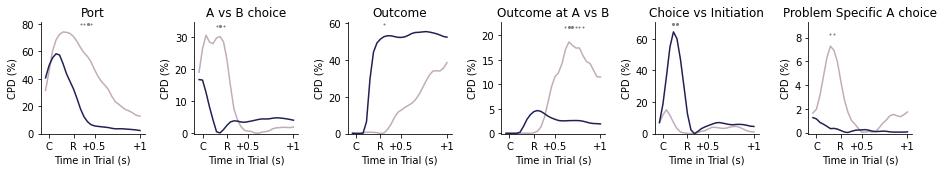

<Figure size 720x360 with 0 Axes>

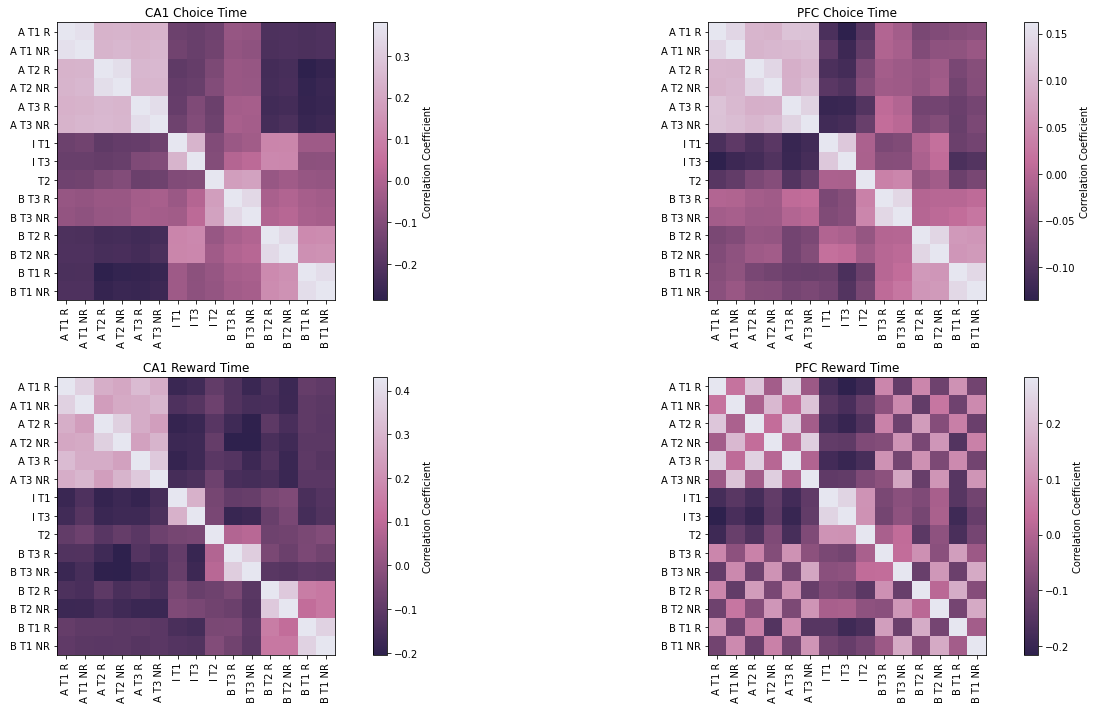

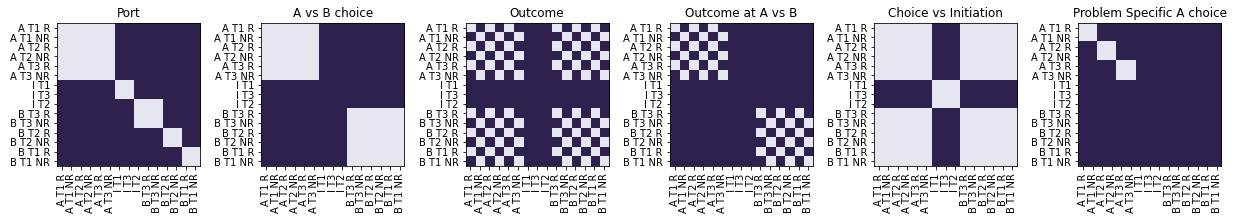

In [36]:
RSA_across_time_plot(HP, PFC, perm_n = True, animal_perm = True, dlc = False)